In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 

# use the whole width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
np.set_printoptions(suppress=True)
sns.set_style("darkgrid")

# Metropolis-Hastings Random Walk Algorithm for Bayesian Inference
This notebook is a simple implementation of the Metropolis-Hasting Algorithm to understand what's going on under the hood.

The key thing to understand: we want to compute a posterior distribution (some θ given some data). 

For this we compute likelihood * prior / normalization_constant. The normalization_constant is the integral of likelihood * prior over all possible prior values. And sometimes this integral is difficult to compute (we don’t have an analytic form of it). 

The Metropolis-Hastings algo solves that problem: it allows to produce samples from a target distribution (p above) (our posterior distribution that is difficult because of the normalization_constant) using another function (g) that is proportional to p, and this is exactly what we have here by choosing g to be likelihood * prior which is easy to compute. At the end of the process, the chain of accepted values follows the posterior distribution.


## Example with the Binomial distribution with a Beta prior

We'll use an example with a binomial distribution with m=10 trials and whose p parameter has a Beta prior distribution. Since the beta distribution is a conjugate prior for the binomial distribution we have an analytic expression of the posterior distribution which lets us verify our implementation.

Assume we have data $x_1$, $x_2$, ..., $x_n$ observations that are the number of successes for n times 10 trials.

If the sampling distribution for x is **binomial(m=10, p)** with m known, and the prior distribution is **beta(α, β)**, the posterior distribution for p is **beta(α + Σ$x_i$, β + m*n – Σ$x_i$)**.

### Prior Distribution with α=4, β=16

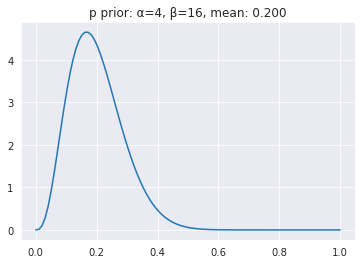

In [2]:
alpha=4; beta=16
x=np.linspace(0,1,100) 
pdf_beta = stats.beta.pdf(x, alpha, beta)
plt.plot(x,pdf_beta)
plt.title('p prior: α=%d, β=%d, mean: %.3f' % (alpha, beta, alpha / (alpha + beta)));

### Posterior Distribution with observations [2,3,4,5]

The posterior distribution is **beta(α=18, β=42)** which has a mean of `18/(18+42) = 0.3`

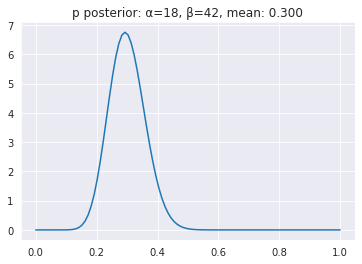

In [11]:
# posterior distribution of p: beta(α + Σxi, β + m*n – Σxi)
m=10
obs = np.array([2,3,4,5])

alpha_post=alpha + obs.sum()
beta_post=beta + m*len(obs) - obs.sum()

pdf_beta = stats.beta.pdf(x, alpha_post, beta_post)
plt.plot(x,pdf_beta)
plt.title('p posterior: α=%d, β=%d, mean: %.3f' % (alpha_post, beta_post, alpha_post / (alpha_post + beta_post)));

- With non informative prior (alpha=beta=1): posterior mean is 0.35
- With alpha=4, beta=16 (mean=0.2): posterior mean is 0.3


## Metropolis-Hastings Random Walk Implementation

The proposal distribution for candidate `p` parameters are is the Normal distribution centered on the previous `p` value with a standard deviation that is adjusted to get an acceptance rate between 20% and 50%.

In [43]:
def log_g(p, observations, binomial_trials, p_prior_alpha, p_prior_beta):
    """
    Computation of the likelihood * prior. The logarithm is taken for numerical stability.
    Args:
    - p: candidate probability for the binomial distribution
    - observations: array containing the number of successes for each experiment.
    - binomial_trials: number of trials (the m parameter in Binomial(m,p))
    - p_prior_alpha: alpha for the prior beta distribution of p.
    - p_prior_beta: beta for the prior beta distribution of p.
    
    Returns:
    - the log of likelihood * prior.
    """
    # The likelihood is the product of the likelihood for each observation. 
    # The log of this product is the sum of the likelihoods.
    log_sum = 0.0
    for obs in observations:
        like = stats.binom.pmf(obs, binomial_trials, p)
        if like < 1e-10:
            # avoid exception for log(0): use a small number: the result is the 
            # same (rejection of that p candidate)
            like = 1e-10
            
        #print('obs: %.d, like: %.3f' % (obs, like))
        log_sum += np.log(like)
        #print('log for obs %d: %.3f' % (obs, np.log(like)))

    # multiply (or add since we compute the logarithm) by the log of rhe prior
    prior = stats.beta.pdf(p, p_prior_alpha, p_prior_beta)
    if prior < 1e-10:
        # avoid exception for log(0): use a small number: the result is the 
        # same (rejection of that p candidate)
        prior = 1e-10
    log_sum += np.log(prior)
    #print('prior: %.3f (log: %.3f), log sum: %.3f' % (prior, np.log(prior), log_sum))
    return log_sum

accept rate: 0.55
0.30040012521085974


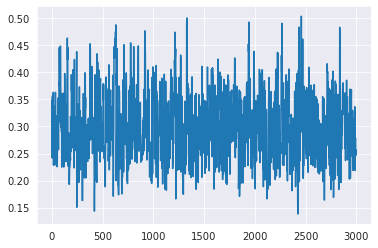

In [49]:
p0 = 0.4
binomial_trials = 10
p_prior_alpha = 4; p_prior_beta = 16

def metropolis_hastings(p0, observations, binomial_trials, p_prior_alpha, p_prior_beta, nb_iter=100):
    chain=[]
    accept_nb = 0 # to keep track of acceptance rate
    last_p = p0
    log_g_last = log_g(last_p, observations, binomial_trials, p_prior_alpha, p_prior_beta)
    #print('log_g_last: %.3f' % log_g_last)
    
    # the candidate proposal function is normal distribution: N(last_p, σ=candidate_sigma)
    candidate_sigma = 0.1
    
    for _ in range(nb_iter):
        # propose new candidate: use normal distribution: N(last_p, σ=0.05)
        p_cand = stats.norm.rvs(loc = last_p, scale = candidate_sigma)
        #print('p_cand: %.3f' % p_cand)
        log_g_cand = log_g(p_cand, observations, binomial_trials, p_prior_alpha, p_prior_beta)
        #print('log_g_cand: %.3f' % log_g_cand)
        
        log_alpha = log_g_cand - log_g_last
        #print('log_alpha: %.3f' % log_alpha)
        alpha = np.exp(log_alpha)
        #print('alpha: %.3f' % alpha)
        
        unif = stats.uniform.rvs(0,1)
        if unif <= alpha:
            #print('accept candidate: alpha: %.3f, unif: %.3f, p_cand: %.3f, log_g_cand: %.3f' % (alpha, unif, p_cand,log_g_cand))
            last_p = p_cand
            log_g_last = log_g_cand
            accept_nb +=1
        #else:
            #print('keep previous: alpha: %.3f, unif: %.3f, last_p: %.3f, log_g_last: %.3f' % (alpha, unif, last_p,log_g_last))
                
        chain.append(last_p)
    print('accept rate: %.2f' % (accept_nb/nb_iter)) # should be between 20% and 50% for random walk
    return np.array(chain)

chain = metropolis_hastings(p0, obs, binomial_trials, p_prior_alpha, p_prior_beta, nb_iter=3000)
plt.plot(chain);
print(chain.mean())

We get the expected mean for the posterior distribution of p

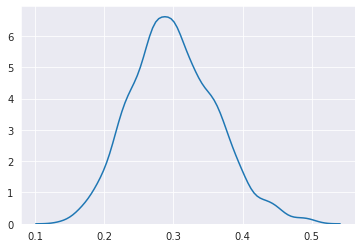

In [50]:
sns.kdeplot(chain);

## Verification with PyMC3

In [52]:
import pymc3 as pm
import arviz as az

In [56]:
with pm.Model() as our_first_model:
    # a priori
    θ = pm.Beta('θ', alpha=p_prior_alpha, beta=p_prior_beta) 
    # likelihood
    y = pm.Binomial('y', p=θ, n=binomial_trials, observed=obs)
    trace = pm.sample(3000, step=[pm.Metropolis()], random_seed=123)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [θ]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████████████████████| 14000/14000 [00:04<00:00, 3147.50draws/s]
The number of effective samples is smaller than 25% for some parameters.


/home/therrmann/dev/anaconda3/envs/ML/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


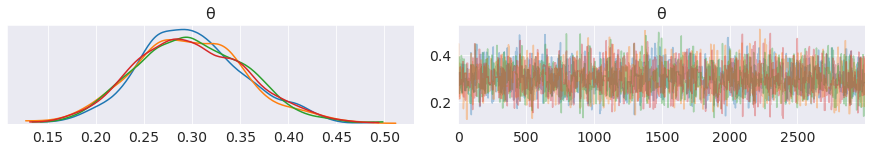

In [57]:
az.plot_trace(trace);

In [58]:
az.summary(trace)

/home/therrmann/dev/anaconda3/envs/ML/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.299,0.057,0.001,0.001,0.193,0.407,2602.0,2602.0,2576.0,3023.0,1.0


The mean is again ~ 0.3